In [1]:
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fftpack import ifft

from sklearn.decomposition import PCA

from collections import deque

In [2]:
import sys
sys.path.append('/home/thomas/projects/fair/call_3/repository/')

from src.pulsed_power_ml.model_framework.data_io import load_binary_data_array
from src.pulsed_power_ml.model_framework.visualizations import add_contour_plot
from src.pulsed_power_ml.model_framework.visualizations import make_gupta_switch_detection_plot
from src.pulsed_power_ml.model_framework.training_data_labelling import remove_false_positive_switching_events

2023-02-24 11:06:01.085038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 11:06:01.349967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 11:06:01.350002: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-24 11:06:02.863854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-2

In [ ]:
r1_1_remove = [1, 4, 7, 10, 13, 16, 19, 22]
r1_2_remove = [1, 4, 7]
r2_2_remove = []

In [ ]:
feature_name_list = [
    'e1_features.csv',
    'f1_features.csv',
    'f2_features.csv',
    'fp1_corrected_features.csv',
    'h2_features.csv',
    'l1_corrected_features.csv',
    'l2_features.csv',
    'r1_features.csv',
    'r2_features.csv'
]
features_base_folder = '/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data'

feature_list = list()

for feature_file in feature_name_list:
    full_path = f'{features_base_folder}/{feature_file}'
    features = np.loadtxt(full_path, delimiter=',')
    feature_list.append(features)

feature_array = np.vstack(feature_list)

In [ ]:
feature_array.shape

In [ ]:
np.savetxt(fname='/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data/merged/features.csv',
           X=feature_array,
           delimiter=',')

In [ ]:
feature_array

In [ ]:
from src.pulsed_power_ml.model_framework.training_data_labelling import remove_false_positive_switching_events

label_name_list = [
    'e1_labels.csv',
    'f1_labels.csv',
    'f2_labels.csv',
    'fp1_corrected_labels.csv',
    'h2_labels.csv',
    'l1_corrected_labels.csv',
    'l2_labels.csv',
    'r1_labels.csv',
    'r2_labels.csv'
]
labels_base_folder = '/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data'

label_list = list()

for label_file in label_name_list:
    full_path = f'{labels_base_folder}/{label_file}'
    labels = np.loadtxt(full_path, delimiter=',')
    label_list.append(labels)

label_array = np.vstack(label_list)

In [ ]:
label_array.shape

In [ ]:
np.savetxt(fname='/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data/merged/labels.csv',
           X=label_array,
           delimiter=',')

In [ ]:
label_array

In [ ]:
BASE_FOLDER = "/home/thomas/projects/fair/call_3/data/"
RAW_DATA_FOLDER = f"{BASE_FOLDER}/raw_data/2022-11-16_training_data/"

TEST_DATA_FOLDER = f'{RAW_DATA_FOLDER}/fp1/'

TEST_VOLTAGE_SPECTRUM = f'{TEST_DATA_FOLDER}/FFTApparentPower_FP1OffOn_FFTSize131072'

OUTPUT_FOLDER = f'/home/thomas/projects/fair/call_3/experiments/gupta_switch_detection/'

FFT_SIZE = 2**17

In [ ]:
data_point_array = read_training_files(TEST_DATA_FOLDER, FFT_SIZE)

In [ ]:
voltage_fft_raw = np.fromfile(TEST_VOLTAGE_SPECTRUM, dtype=np.float32)
remainder = len(voltage_fft_raw) % FFT_SIZE
if remainder != 0:
    voltage_fft_raw = voltage_fft_raw[:-remainder].reshape((-1, FFT_SIZE))
else:
    voltage_fft_raw = voltage_fft_raw.reshape((-1, FFT_SIZE))

In [3]:
def watt_to_dbm(spectrum):
    return 10 * np.log10(spectrum) + 30

In [4]:
def gupta_switch_detection(raw_spectrum_array, window_size=25):

    spectrum_array = list()

    for spectrum in raw_spectrum_array:
        spectrum_dbm = watt_to_dbm(spectrum)
        spectrum_array.append(spectrum_dbm)

    spectrum_array = np.array(spectrum_array)

    index = 0

    difference_vector_max = list()

    while True:
        try:
            i, j, k = index*window_size, (index+1)*window_size, (index+2)*window_size
            background = np.mean(spectrum_array[i:j], axis=0)
            new_window = np.mean(spectrum_array[j:k], axis=0)
            difference_vector = background - new_window
            difference_vector_max.append(np.abs(difference_vector).max())
            index += 1

            if k > len(spectrum_array):
                break

        except:
            print(f'Exception! {i, j, k}, {len(spectrum_array)}')
            break

    return difference_vector_max

In [12]:
e1_data_point_array = load_binary_data_array(
    '/home/thomas/projects/fair/call_3/data/2023-02-22_training-data/r1_1.dat',
    fft_size_data_point=2**16
)

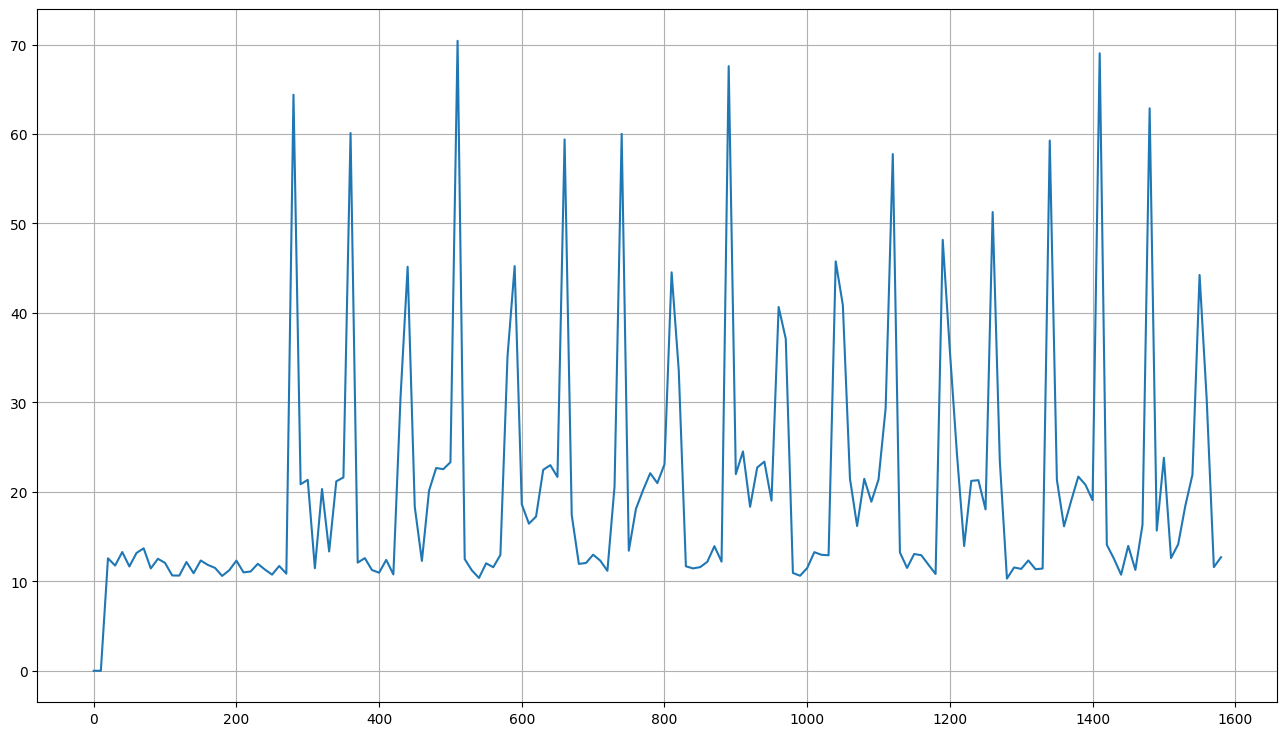

In [13]:

window_size = 10

gupta_switch_vector = gupta_switch_detection(e1_data_point_array[:,2 * 2**16:3*2**16], window_size=window_size)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(
    np.array(range(len(gupta_switch_vector))) * window_size,
    list([0]) * 2 + gupta_switch_vector[:-2]
)
# ax.hlines(y=2000, xmin=0, xmax=2000)
ax.grid(True)

In [ ]:
path_to_feature_file = '/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data/fp1_features.csv'
features = np.loadtxt(path_to_feature_file, delimiter=',')

In [ ]:
switch_positions_file = '/home/thomas/projects/fair/call_3/data/training_data/model_v3/training_data/fp1_switch_positions.csv'
switch_positions = np.loadtxt(switch_positions_file, delimiter=',')

In [ ]:
raw_spectrum_array = data_point_array[:, int(2 * FFT_SIZE / 2) : int(3 * FFT_SIZE / 2)]
# spectrum_array = list()

apparent_power_array = data_point_array[:, -2]

# for spectrum in raw_spectrum_array:
#     spectrum_dbm = watt_to_dbm(spectrum)
#     spectrum_array.append(spectrum_dbm)

# spectrum_array = np.array(spectrum_array)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.grid(True)
ax.plot(apparent_power_array)
ax.plot(switch_positions * max(apparent_power_array),
        alpha=0.5)

original_switch_indices = np.nonzero(switch_positions)[0]

for i, s in enumerate(original_switch_indices):
    y = -1.25 if i%2!=0 else -0.5
    ax.text(x=s,
            y=y,
            s=i)

In [ ]:
def remove_false_positive_switching_events(feature_vector_array: np.array,
                                           switch_positions: np.array,
                                           switching_events_to_remove: np.array) -> Tuple[np.array, np.array]:
    """
    Remove false-positive switching events from a feature_vector_array and the corresponding switch_positions array.

    Parameters
    ----------
    feature_vector_array
        2D array containing one feature vector for each switching event.
    switch_positions
        Array with the same length as the original data point array containing 1s for each detected switch otherwise 0s.
    switching_events_to_remove
        Array of indices corresponding to the feature_vector_array of false-positive switching events. These switching
        events will be removed.

    Returns
    -------
    corrected_feature_vector_array
        features_vector_array w/o the features of false-positive switching events.
    corrected_switch_positions
        Array w/ the same length as switch_positions, but w/o the false positive switching events (the respective 1s
        will be 0s)
    """
    corrected_feature_vector_array = np.delete(feature_vector_array, switching_events_to_remove, axis=0)

    original_switch_indices = np.nonzero(switch_positions)[0]

    print(original_switch_indices)

    switch_flags_to_change = original_switch_indices[switching_events_to_remove]

    corrected_switch_positions = np.copy(switch_positions)

    corrected_switch_positions[switch_flags_to_change] = 0

    return corrected_feature_vector_array, corrected_switch_positions

In [ ]:
false_switch_positions = [
    1, 4, 7, 10, 13, 14, 19, 20, 24, 26, 27, 30, 32, 36, 37, 42, 43,
]

In [ ]:
len(false_switch_positions)

In [ ]:
corrected_features, corrected_switches = remove_false_positive_switching_events(
    features,
    switch_positions,
    np.array(false_switch_positions, dtype=np.int32)
)

In [ ]:
raw_spectrum_array = data_point_array[:, int(2 * FFT_SIZE / 2) : int(3 * FFT_SIZE / 2)]
spectrum_array = list()

apparent_power_array = data_point_array[:, -2]

for spectrum in raw_spectrum_array:
    spectrum_dbm = watt_to_dbm(spectrum)
    spectrum_array.append(spectrum_dbm)

spectrum_array = np.array(spectrum_array)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.grid(True)
ax.plot(apparent_power_array)
ax.plot(corrected_switches * max(apparent_power_array),
        alpha=0.5)

In [ ]:
corrected_features.shape

In [ ]:
np.nonzero(corrected_switches)[0].shape

In [ ]:
a = " 1 2 3 4 5 6 "

In [ ]:
a_int = [int(x) for x in a.split(' ') if len(x) !=0]

In [ ]:
int('asdf')

In [ ]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [ ]:
pca_features[[0, 2, 4, 5]]

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.scatter(x=pca_features[:, 0],
           y=pca_features[:, 1])
ax.grid(True)

In [ ]:
fig.savefig('/home/thomas/projects/fair/call_3/experiments/gupta_switch_detection/reimplemented_gupta_switch_detection/intermediate/FP1_dbm_threshold.pdf')

In [ ]:
def add_contour_plot_dbm(spectrum: np.array,
                         min_max_freq: List[float],
                         ax: mpl.axis.Axis) -> mpl.axis.Axis:
    """
    Add a contour plot of the provided spectrum to *axes*.

    Parameters
    ----------
    spectrum
        Array containing the magnitude per frequency.
    min_max_freq:
        Array containing the min frequency and the max frequency.
    ax
        Axis object to add the plot to.

    Returns
    -------
    ax
        the provided axis object with the respective plot added.
    """

    # add spectrum to axis
    ax.imshow(X=10 * np.log10(spectrum.T**2 / 50.0) + 30,
              aspect="auto",
              interpolation="none",
              origin="lower",
              cmap=mpl.colormaps["rainbow"])

    # add frequency ticks to y-axis
    y_labels = np.arange(min_max_freq[0], min_max_freq[1]+1, 250)
    y_ticks_position_list = np.linspace(0, len(spectrum[0]), len(y_labels))
    ax.set_yticks(ticks=y_ticks_position_list,
                  labels=y_labels)
    ax.set_ylabel("Frequency [kHz]")

    # add time ticks
    ax.set_xlabel("Timestep")

    # Miscellaneous
    ax.grid(True)

    return ax

In [ ]:
def invert_fft(spectrum_array: np.array, fft_size: int) -> np.array:
    signal_list = list()
    for spectrum in spectrum_array:
        signal = ifft(spectrum)
        signal_list.append(signal)

    signal_sequence = np.array(signal_list).flatten()

    return signal_sequence

In [ ]:
signal_seq = invert_fft(voltage_fft_raw, FFT_SIZE)

In [ ]:
plt.plot(signal_seq)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
real_part = voltage_fft_raw[:500, 0:int(FFT_SIZE/2)]
ax = add_contour_plot_dbm(real_part,
                          [0, 1000],
                          ax)
fig.savefig(f'{OUTPUT_FOLDER}/mixed1_voltage_spectrum_dBm.png', dpi=1600)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
real_part = voltage_fft_raw[:500,327:int(FFT_SIZE/2)]
ax = add_contour_plot_dbm(real_part,
                          [10, 1000],
                          ax)
#fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_spectrum_50k_dbm.png', dpi=400)
fig.savefig(f'{OUTPUT_FOLDER}/mixed_voltage_spectrum_10k_dbm.png', dpi=1600)

In [ ]:
def clean_spectra(spectrum_array: np.array, background_n: int = 25, threshold: float = 10) -> np.array:
    background_array = deque(maxlen=background_n)
    output_array = np.full(spectrum_array.shape, np.nan)
    for index, spectrum_v in enumerate(spectrum_array):

        spectrum = 10 * np.log10(spectrum_v**2 / 50.0) + 30

        # Fill up background array until full
        if len(background_array) < background_n:
            background_array.append(spectrum)
            continue

        # clean current spectrum
        averaged_background = np.array(background_array).mean(axis=0)
        residual_spectrum = spectrum - averaged_background
        output_array[index] = residual_spectrum

        # check for switching event
        # if residual_spectrum.max() >= threshold

        background_array.append(spectrum)

    return output_array

In [ ]:
real_part = voltage_fft_raw[: ,1180:int(FFT_SIZE/2)]
cleaned_spectra = clean_spectra(real_part, 10)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(cleaned_spectra.max(axis=1))
ax.grid()

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(cleaned_spectra.min(axis=1))
ax.grid()

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(np.abs(cleaned_spectra).max(axis=1))
ax.grid()

In [ ]:
plt.plot(cleaned_spectra.min(axis=1))

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax = add_contour_plot_dbm(cleaned_spectra,
                          [3, 1000],
                          ax)
#fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_spectrum_50k_dbm.png', dpi=400)
fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_cleaned_spectrum_10k_dbm.png', dpi=1600)

In [ ]:
a = np.zeros(10)

In [ ]:
a

In [ ]:
a[3:5] = 1

In [ ]:
a